In [1]:
# ! pip install imutils
# ! pip install scikit-image
# ! pip install tensorflow
import argparse
import imutils
import cv2

from os import listdir
import cv2
import sys
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure
from tensorflow.keras.models import load_model
import pickle

input_path = '../data/Set1Part0'
output_path = "pikles"
img_size=(30,30,3)


#Read in image files
# images_files = [f for f in listdir(input_path + 'dataset')]
images_files = [f for f in listdir(input_path)]

images_files = images_files[100:150]

images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
sign_or_not = pickle.load(open("sign_or_not_classifier.pkl", 'rb'))


def classify_signs(classifier_model, img_list, confidence):
    # returns 1 if sign, 0 if not
    
    flat_data_arr_ = []
    
    for i in img_list:
        flat_data_arr_.append(cv2.resize(i, [32, 32]).flatten())
    
    flat_data_=np.array(flat_data_arr_)

    df_=pd.DataFrame(flat_data_) #dataframe
    df_['Target']="useless"
    x_=df_.iloc[:,:-1] #input data 
    
    pred = classifier_model.predict_proba(x_)
    
    print(pred)
    
    preds = []
    for i in pred:
        if i[0] >= confidence:
            preds.append(0)
        else:
            preds.append(1)
    return preds

def blue_mask(img):
    
    # img = constrastLimit(img)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # lower_blue= np.array([70,158,74])
    # upper_blue = np.array([138,255,255])
    
    # good blue values
    # lower_blue= np.array([70,158,74])
    # upper_blue = np.array([138,255,210])
    
    lower_blue= np.array([70,158,24])
    upper_blue = np.array([138,255,210])
    # 210,84,99

    mask = cv2.inRange(hsv,lower_blue,upper_blue)
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(mask, cnt, -1, (0,255,10), 3)
    cv2.drawContours(mask, cnt, -1, (0,255,40), 3)
    
    return mask
    

def red_mask(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # mask2 = cv2.inRange(hsv, (80, 70, 130), (255, 255, 255))
    
    # lower_red = np.array([0,50,50])
    # upper_red = np.array([12,255,255])
    
    lower_red = np.array([0,40,30])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    
    # lower_red = np.array([170,50,50])
    # upper_red = np.array([182,255,255])
    lower_red = np.array([240,40,30])
    upper_red = np.array([255,255,225])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 8)
    
    
    return mask

def yellow_mask(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # lower_yellow= np.array([20,150,100])
    # upper_yellow = np.array([30,255,255])
    
    lower_yellow= np.array([20,158,100])
    upper_yellow = np.array([30,255,250])

    mask = cv2.inRange(hsv,lower_yellow,upper_yellow)
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (255,0,0), 3)
    
    return mask

def coordsIntersect(candidate_coords, list_coords):
    
    x,y,w,h = candidate_coords
    # middle point
    can_x, can_y = ((2*x+w)/2 , (2*y+h)/2)
    
    for coord_comb in list_coords:
        x_, y_, w_, h_ = coord_comb
        
        # if middle point of candidate is inside any existing rect then return False
        if (can_x < (x_ + w_)) & (can_x > x_):
            if (can_y < (y_ + h_)) & (can_y > y_):
                return False
        
    return True


def return_interesting_area_coords(img, confi):
    
    ROIs = []
    
    img_og = img.copy()
    
    red_masked = red_mask(img)
    blue_masked = blue_mask(img)
    yellow_masked = yellow_mask(img)
    
    
    sizeParam = int((img.shape[0] * img.shape[1]) / 100000)
    
    
    size = (sizeParam, sizeParam)
    
    
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)
    # double cant hurt 
    min_image = cv2.dilate(blue_masked, kernel)
    # min_image = cv2.dilate(min_image, kernel)
    
    blue_masked = min_image
    
    
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)
    # double cant hurt 
    min_image = cv2.dilate(red_masked, kernel)
    # min_image = cv2.dilate(min_image, kernel)
    
    red_masked = min_image
    
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)
    # double cant hurt 
    min_image = cv2.dilate(yellow_masked, kernel)
    # min_image = cv2.dilate(min_image, kernel)
    
    yellow_masked = min_image
    

    # combine_mask = red_masked + blue_masked
    
    fig, axs = plt.subplots(5, 1, figsize=(30,60))
    RGB_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    axs[0].imshow(RGB_img)
    axs[0].set_title('Original')
    axs[1].imshow(red_masked)
    axs[1].set_title('Red mask')
    axs[2].imshow(blue_masked)
    axs[2].set_title('Blue mask')
    axs[3].imshow(yellow_masked)
    axs[3].set_title('Yellow mask')
    

    
    masks = [red_masked, blue_masked, yellow_masked]
    
    combined_masks = red_masked + blue_masked + yellow_masked

    for maskerino in masks:
        cnts = cv2.findContours(maskerino.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(cnts)
        
        
        for contour in contours:
            approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
            x = approx.ravel()[0]
            y = approx.ravel()[1] - 5

            coords = cv2.boundingRect(approx)
            x, y , w, h = coords
            aspectRatio = float(w)/h

            if(cv2.contourArea(approx) > sizeParam*25):
                # cv2.drawContours(img, [approx], 0, (0, 0, 255), 25)
                cv2.drawContours(combined_masks, [approx], 0, (255, 0, 0), 15)
                print(coords, len(approx))
                if len(approx) == 3:
                    # cv2.putText( RGB_img, "Triangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0) )
                    if aspectRatio >= 0.9 and aspectRatio <= 1.1:
                        if coordsIntersect(coords, ROIs):
                            ROIs.append(coords)
                elif len(approx) == 4 :
                    if aspectRatio <= 1.3:
                        if coordsIntersect(coords, ROIs):
                            ROIs.append(coords)
    #                 if aspectRatio >= 0.95 and aspectRatio < 1.05:
    #                     cv2.putText(RGB_img, "square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
    #  
    #                 else:
    #                     cv2.putText(RGB_img, "rectangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
                else:
                    if aspectRatio >= 0.60 and aspectRatio <= 1.25:
                        if coordsIntersect(coords, ROIs):
                            ROIs.append(coords)
                    # cv2.putText(RGB_img, "circle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
                    
    axs[4].imshow(combined_masks)
    axs[4].set_title('Combined masks with contours')
    
    list_of_sign_imgs = []
    list_of_filtered_ROI = []
    
    print("ROI LEN:", len(ROIs))
    
    # plt.imshow(img)
    

    for i in ROIs:
        x,y,w,h = i
        spec_img = cv2.resize(img_og[y:y+h, x:x+w], (32, 32))
        list_of_sign_imgs.append(spec_img)
        print(x,y,w,h)

    
    preds = classify_signs(sign_or_not, list_of_sign_imgs, confi)
    print(preds)
    b = np.where(preds)
    coordinates = [e for i, e in enumerate(ROIs) if i in b[0]]
    
    return coordinates

2021-12-14 15:26:05.171700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 15:26:05.171727: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
loaded_model = load_model('../final_pipeline/Trafic_signs_model_final.h5')

2021-12-14 15:26:22.211161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-14 15:26:22.211191: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-14 15:26:22.211217: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hendrik-HP-EliteBook-840-G6): /proc/driver/nvidia/version does not exist
2021-12-14 15:26:22.211774: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load dictionary for translating predictions
a_file = open("../final_pipeline/char_to_int.pkl", "rb")
char_to_int = pickle.load(a_file)
print(char_to_int)

{'100_SIGN': 0, '10_SIGN': 1, '110_SIGN': 2, '120_SIGN': 3, '130_SIGN': 4, '15_SIGN': 5, '20_SIGN': 6, '25_SIGN': 7, '30_SIGN': 8, '40_SIGN': 9, '50_SIGN': 10, '5_SIGN': 11, '60_SIGN': 12, '70_SIGN': 13, '80_SIGN': 14, '80_SIGN_END': 15, '90_SIGN': 16, 'ALL_END': 17, 'BUMP': 18, 'CHILDREN': 19, 'CROSSROADS_PRIORITY_RIGHT': 20, 'CROSSROADS_WITH_MINOR': 21, 'CURVES_FIRST_LEFT': 22, 'CURVES_FIRST_RIGHT': 23, 'CURVE_LEFT': 24, 'CURVE_RIGHT': 25, 'CYCLE_PATH': 26, 'CYCLISTS': 27, 'DANGER': 28, 'DOMESTIC_ANIMALS': 29, 'GIVE_WAY': 30, 'GIVE_WAY_TO_ONCOMING': 31, 'GO_LEFT': 32, 'GO_STRAIGHT': 33, 'GO_STRAIGHT_OR_TURN_LEFT': 34, 'GO_STRAIGHT_OR_TURN_RIGHT': 35, 'HEIGHT_LIMIT': 36, 'ICE_OR_SNOW': 37, 'LEVEL_CROSSING_WITH_BARRIERS_AHEAD': 38, 'MISC': 39, 'NO_ENTRY': 40, 'NO_LEFT_TURN': 41, 'NO_OVERTAKING': 42, 'NO_OVERTAKING_END': 43, 'NO_OVERTAKING_HEAVY': 44, 'NO_OVERTAKING_HEAVY_END': 45, 'NO_PARKING': 46, 'NO_PARKING_FROM_1ST_TO_15TH': 47, 'NO_PEDAL_CYCLES': 48, 'NO_RIGHT_TURN': 49, 'NO_STOPP

In [4]:
def prediction_to_label(model, X_test, char_to_int):
    predictions = model.predict(X_test)
    predictions = [np.argmax(x) for x in predictions]
    int_to_char = {k:v for k,v in zip(char_to_int.values(),char_to_int.keys())}
    labels_predicted = [int_to_char[integer] for integer in predictions]
    return labels_predicted

In [5]:
def classify_ROI(img, confi):
    
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ROI_coords = return_interesting_area_coords(img.copy(), confi)
    signs = []
    # plt.imshow(img)
    for i in ROI_coords:
        x,y,w,h = i
        spec_img = img[y:y+h, x:x+w]
        image = exposure.equalize_adapthist(spec_img, clip_limit=0.1)
        image = cv2.resize(image, (50, 50))
        print(image.shape)
        
        signs.append(np.array(image))
        
    signs = np.array(signs)
    # plt.imshow(signs[3])
    preds = prediction_to_label(loaded_model, signs,char_to_int)
    print(preds)
    
    coords_and_classifications = {k:v for k,v in zip(ROI_coords,preds)}
    print(coords_and_classifications)
    
    for i in coords_and_classifications:
        x,y,w,h = i
        class_ = coords_and_classifications[i]
        cv2.putText(RGB_img, class_, (x, y-5), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0) )
        cv2.rectangle(RGB_img, (x, y), (x+w, y+h), (255,0,0), 2)
    
    return RGB_img

In [6]:
images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
plt.figure(figsize=(32, 32))
image_to_test = (images[images_files[3]])

box1 = (499, 571, 49, 49)
box2 = (492, 564, 63, 63)

coordsIntersect(box1, [box2])

False

<Figure size 2304x2304 with 0 Axes>

In [14]:
images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))

# Running the code with pictures

In [41]:
## MAIN TESTING CELL

plt.figure(figsize=(32, 32))
image_to_test = (images[images_files[36]])
later_og = image_to_test.copy()

<Figure size 2304x2304 with 0 Axes>

(1144, 508, 74, 77) 11
(480, 691, 33, 18) 10
(1162, 659, 57, 38) 4
(1163, 596, 44, 56) 15
(1155, 524, 58, 46) 12
ROI LEN: 2
1144 508 74 77
1163 596 44 56
[[7.88132238e-02 9.21186776e-01]
 [3.00000090e-14 1.00000000e+00]]
[1, 1]
(50, 50, 3)
(50, 50, 3)
['100_SIGN', 'PRIORITY_ROAD']
{(1144, 508, 74, 77): '100_SIGN', (1163, 596, 44, 56): 'PRIORITY_ROAD'}


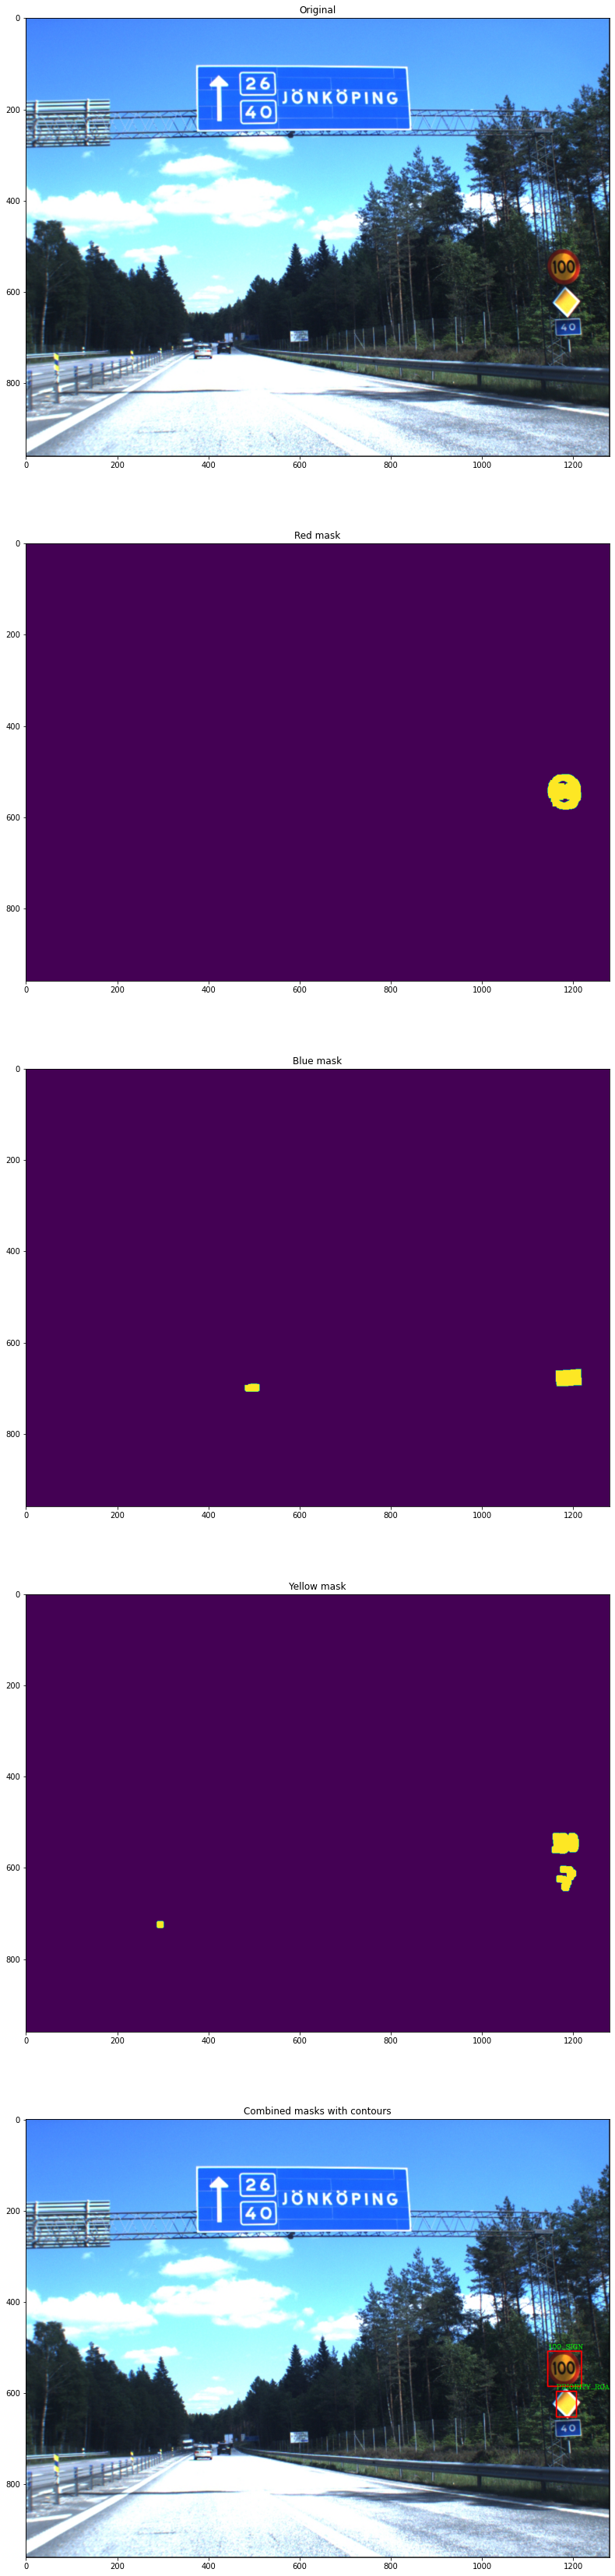

In [42]:
# Replace image_to_test with your desired picture - 36

imag = classify_ROI(image_to_test, 0.8)
plt.imshow(imag)

### Testing around which we decided to keep in, but is irrelevant to the main workflow

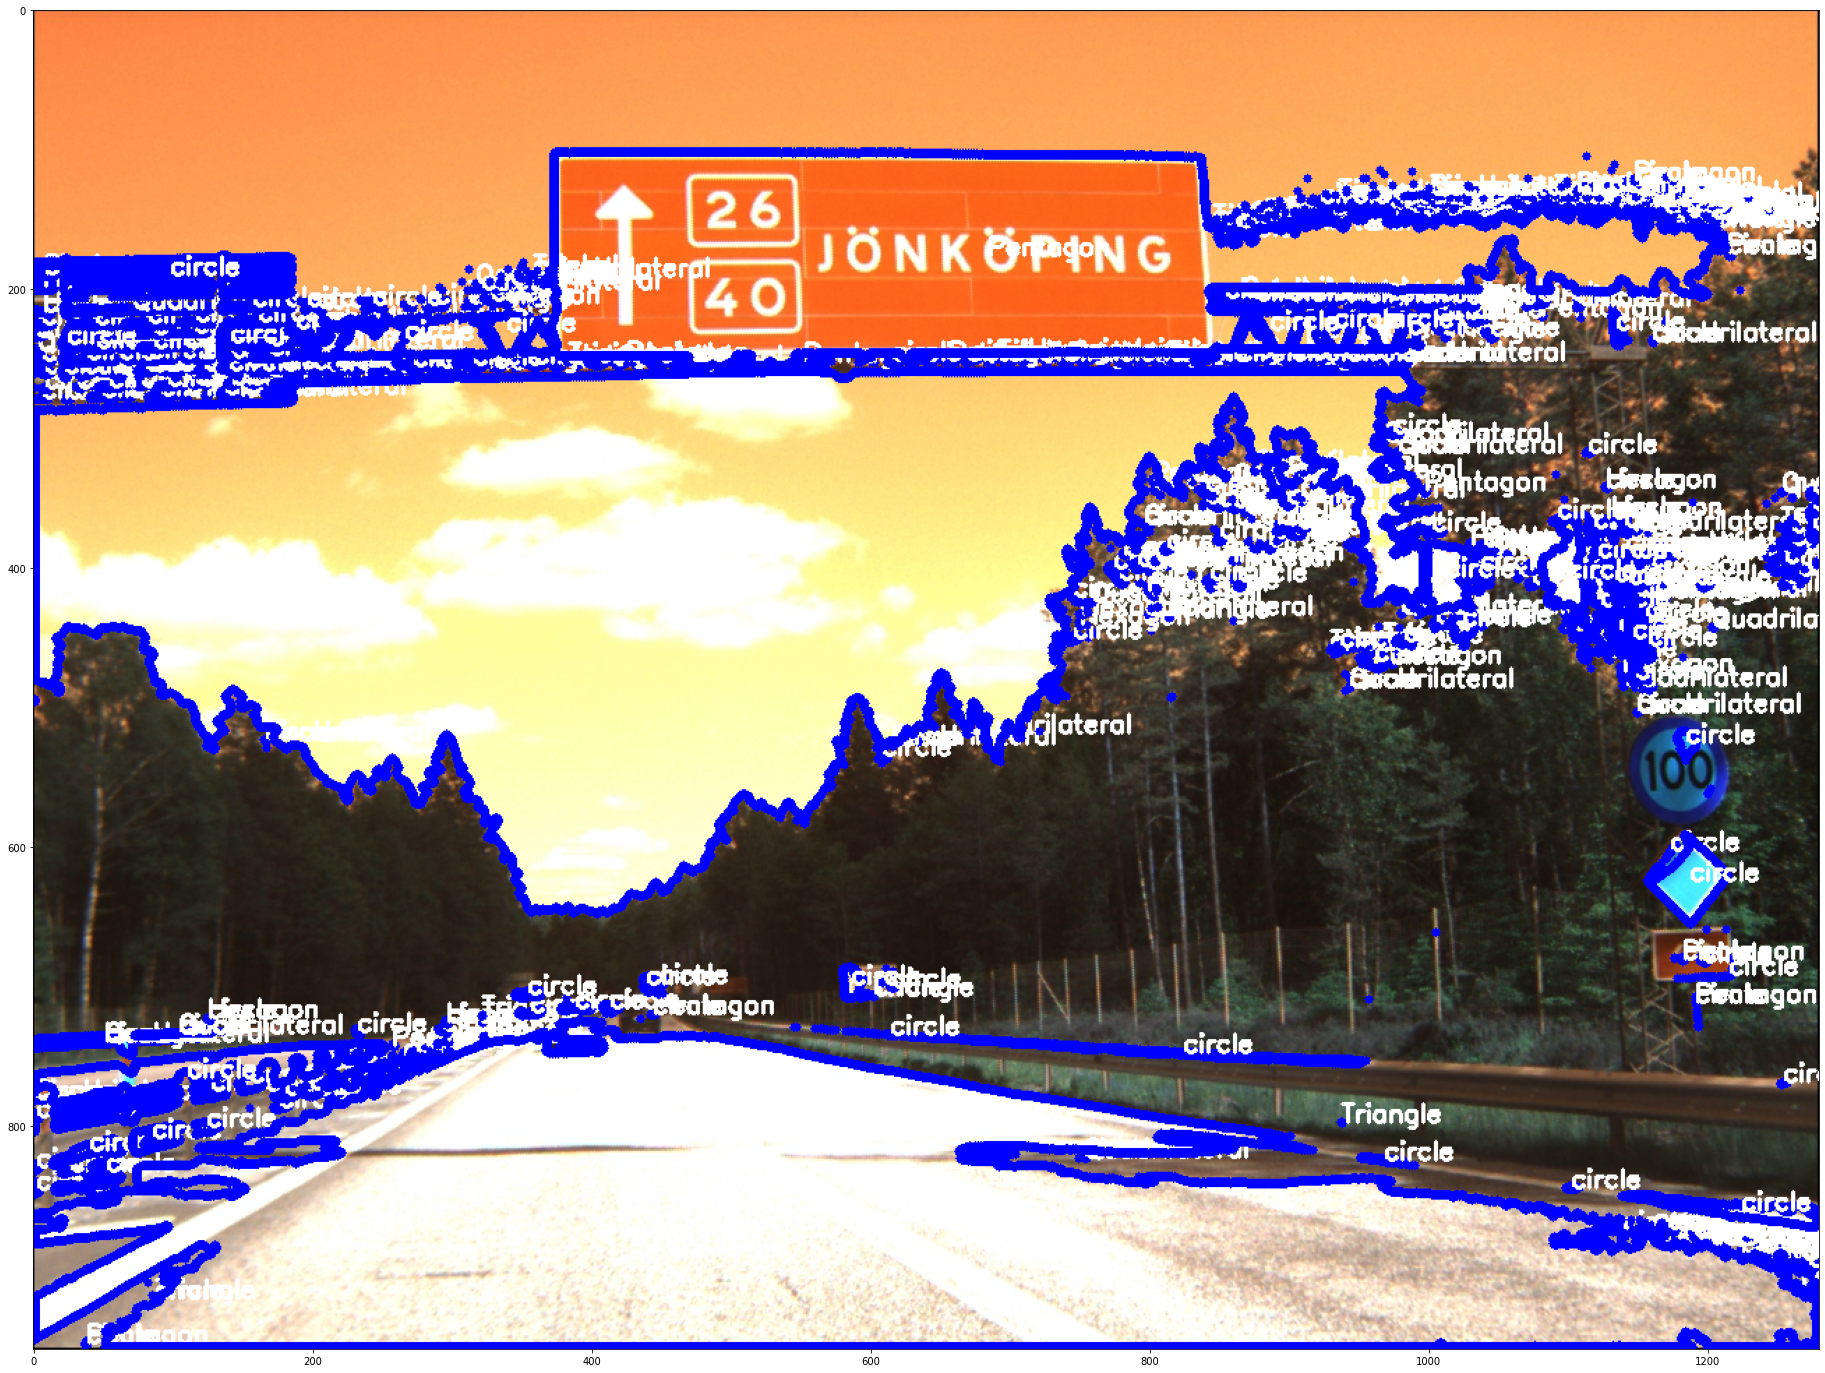

In [21]:
image_to_test = (images[images_files[36]])
plt.figure(figsize=(32,32))

imo = image_to_test.copy()

gray = cv2.cvtColor(imo, cv2.COLOR_BGR2GRAY)
  
# setting threshold of gray image
_, threshold = cv2.threshold(gray, 167, 255, cv2.THRESH_BINARY)
  
# using a findContours() function
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
i = 0
  
# list for storing names of shapes
for contour in contours:
  
    # here we are ignoring first counter because 
    # findcontour function detects whole image as shape
    if i == 0:
        i = 1
        continue
  
    # cv2.approxPloyDP() function to approximate the shape
    approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
      
    # using drawContours() function
    cv2.drawContours(imo, [contour], 0, (0, 0, 255), 5)
  
    # finding center point of shape
    M = cv2.moments(contour)
    if M['m00'] != 0.0:
        x = int(M['m10']/M['m00'])
        y = int(M['m01']/M['m00'])
  
    # putting shape name at center of each shape
    if len(approx) == 3:
        cv2.putText(imo, 'Triangle', (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
  
    elif len(approx) == 4:
        cv2.putText(imo, 'Quadrilateral', (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
  
    elif len(approx) == 5:
        cv2.putText(imo, 'Pentagon', (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
  
    elif len(approx) == 6:
        cv2.putText(imo, 'Hexagon', (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
  
    else:
        cv2.putText(imo, 'circle', (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
  
plt.imshow(imo)

## Some mild testing of filtering out the sky, which, even based on the example in the current out cell, seemed fruitless, as it would be hard to separate the sky from blue signs

98


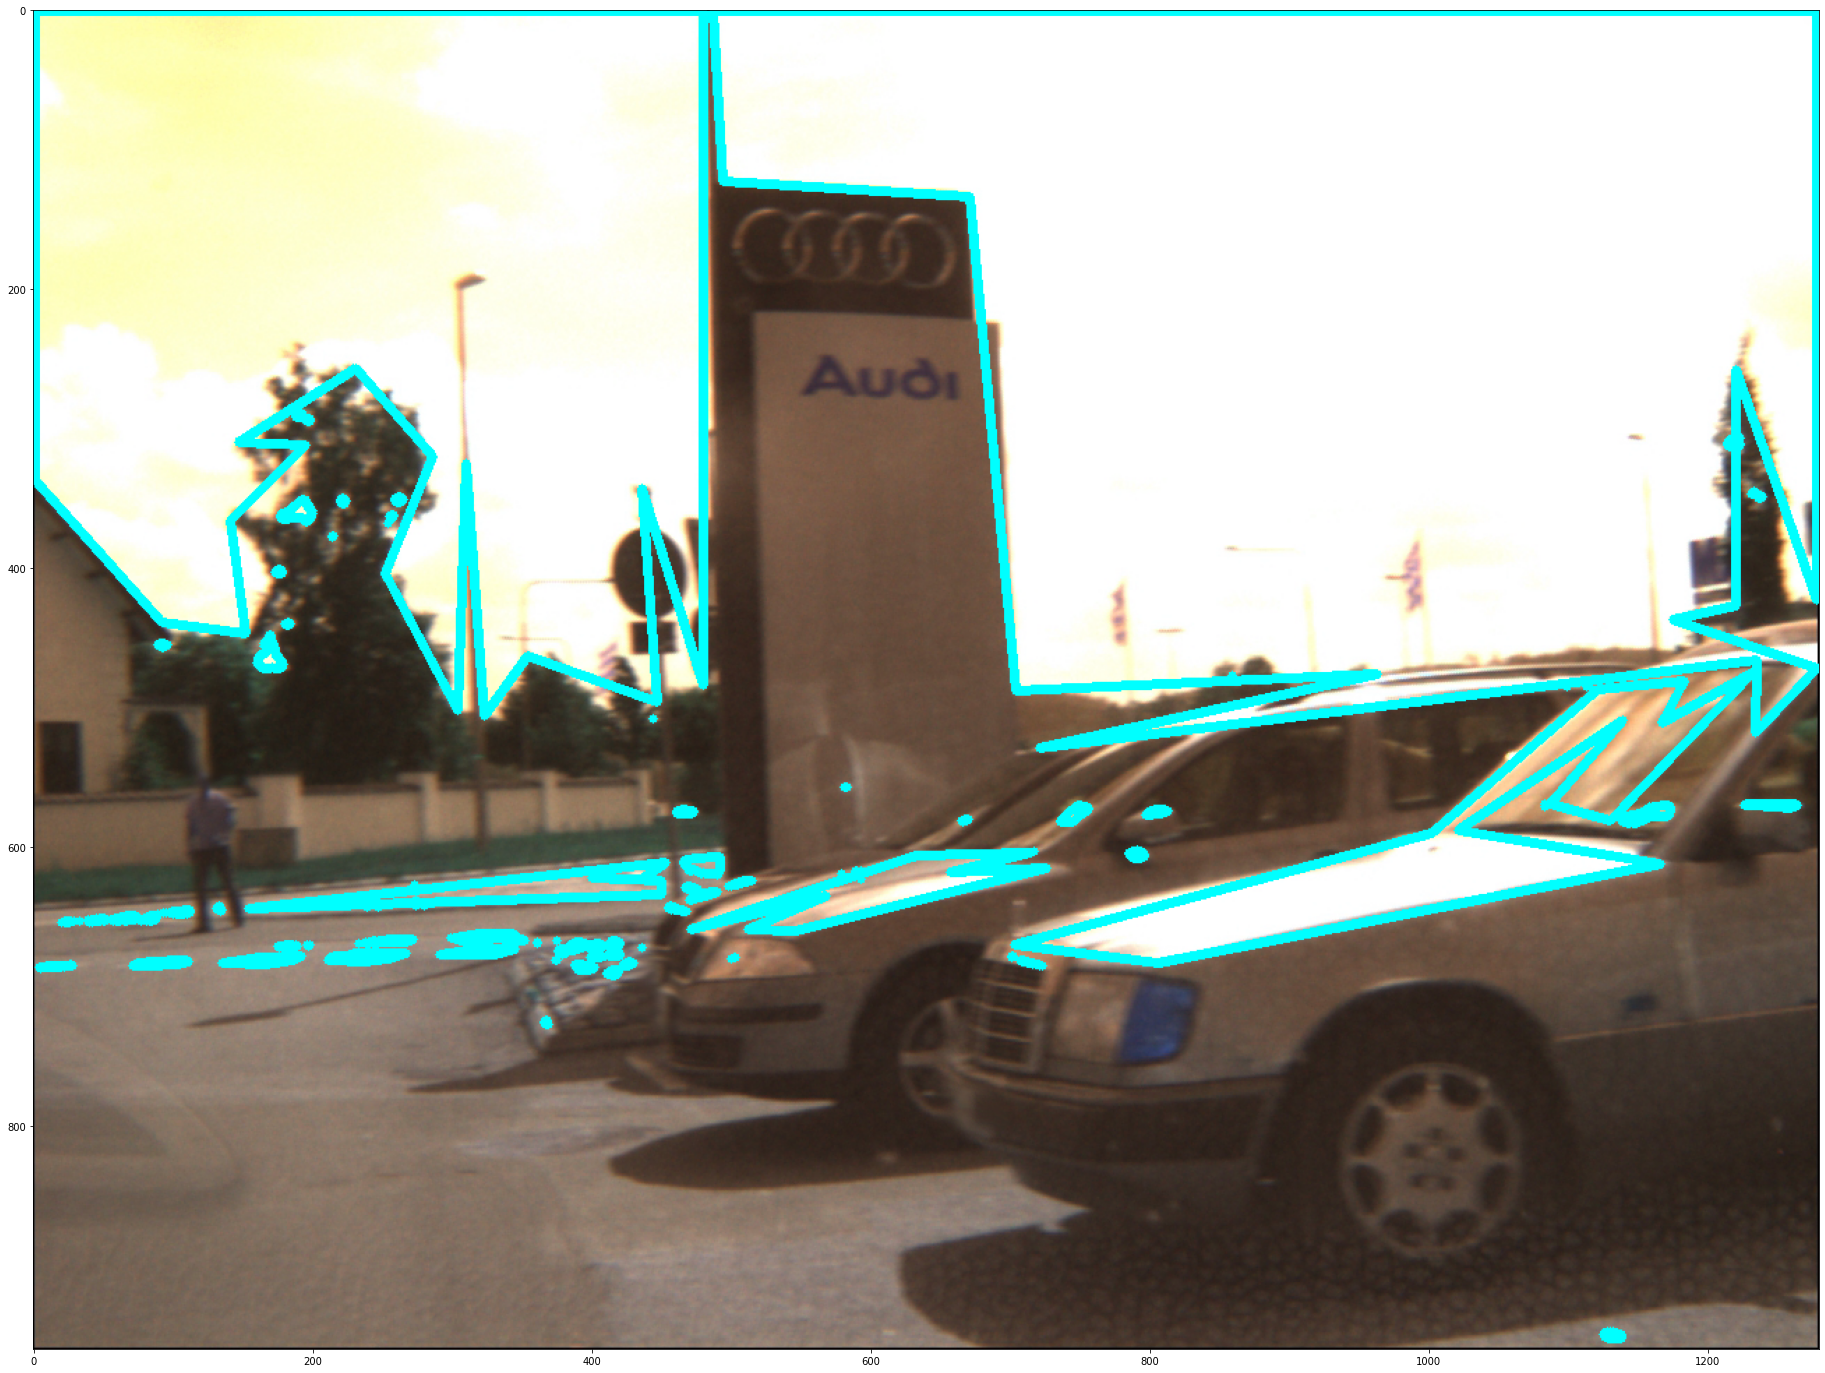

In [34]:
image_to_test = (images[images_files[17]])
plt.figure(figsize=(32,32))

imo = image_to_test.copy()

gray = cv2.cvtColor(imo, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

cnts = cv2.findContours(binary, cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(cnts)
print(len(contours))


for contour in contours:
    epsilon = 0.009 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, closed=True)
    cv2.drawContours(imo, [approx], 0, (0, 255, 255), 5)

plt.imshow(imo)
# approx = cv2.approxPolyDP(gray, 0.01* cv2.arcLength(contour, True), True)
# x = approx.ravel()[0]
# y = approx.ravel()[1] - 5

# coords = cv2.boundingRect(approx)
# x, y , w, h = coords

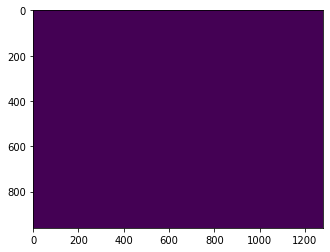

In [35]:
blue_masked = blue_mask(image_to_test)
plt.imshow(blue_masked)

cnts = cv2.findContours(blue_masked.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(cnts)

for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
    x = approx.ravel()[0]
    y = approx.ravel()[1] - 5

    coords = cv2.boundingRect(approx)
    print(coords)

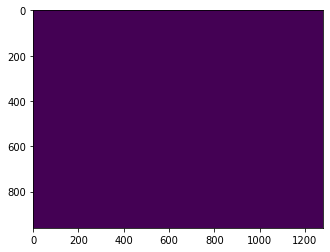

In [36]:
im_in = blue_masked

size = (25, 25)
shape = cv2.MORPH_RECT
kernel = cv2.getStructuringElement(shape, size)
min_image = cv2.dilate(im_in, kernel)

plt.imshow(min_image)
